In [222]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
batch_size = 64
num_epochs = 75

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Using device: cuda


In [223]:
def load_datasets(base_path="./"):
    
    files = {
        "train": "cs-training.csv",
    }

    dfs = {}
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        
    return dfs

def dataset_summary(df, show_counts=True):
    
    total_rows = len(df)
    total_duplicates = df.duplicated().sum()
    
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "non_null_count": df.notna().sum(),
        "missing_count": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique_count": df.nunique(),
        "duplicates_in_dataset": total_duplicates 
    })
    
    print(f"Dataset shape: {df.shape}")
    if show_counts:
        print(f"Total rows: {total_rows}")
        print(f"Total duplicate rows: {total_duplicates}")
    
    summary = summary.sort_values(by="missing_%", ascending=False)
    
    return summary

def check_and_drop_duplicates(df, target=None):

    total_duplicates = df.duplicated().sum()
    
    if total_duplicates > 0:
        df_cleaned = df.drop_duplicates()
        print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
        
        if target is not None:
            target_cleaned = target.loc[df_cleaned.index]
            return df_cleaned, target_cleaned
        
        return df_cleaned
    else:
        print("No duplicate rows found")
        
        if target is not None:
            return df, target
            
        return df

def drop_target_and_ids(df):
    
    df_copy = df.copy()

    feature_cols_to_drop =["SeriousDlqin2yrs"];
    
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)

    print(f"Returning raw features and target")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):

    df_engi = df.copy()

    df_engi["TotalPastDue"] = df_engi["NumberOfTime30-59DaysPastDueNotWorse"] + \
                             df_engi["NumberOfTimes90DaysLate"] + \
                             df_engi["NumberOfTime60-89DaysPastDueNotWorse"]

    df_engi['HasDelinquencyBinary'] = (df_engi['TotalPastDue'] > 0).astype(int)

    df_engi['MajorDelinquencyBinary'] = (df_engi['NumberOfTimes90DaysLate'] > 0).astype(int)

    df_engi['HasMonthlyIncomeBinary'] = df_engi['MonthlyIncome'].notna().astype(int)

    df_engi['MonthlyDebtAmount'] = df_engi['DebtRatio'] * df_engi['MonthlyIncome']

    df_engi['AvailableCreditRatio'] = df_engi['NumberOfOpenCreditLinesAndLoans'] / \
                                      df_engi['NumberRealEstateLoansOrLines']

    df_engi['Log_MonthlyIncome'] = np.log1p(df_engi['MonthlyIncome'])

    df_engi['UtilToAgeRatio'] = df_engi['RevolvingUtilizationOfUnsecuredLines'] / df_engi['age']

    def credit_mix(row):
        if row['NumberRealEstateLoansOrLines'] == 0 and row['NumberOfOpenCreditLinesAndLoans'] == 0:
            return 'NoCredit'
        elif row['NumberRealEstateLoansOrLines'] > 0 and row['NumberOfOpenCreditLinesAndLoans'] == 0:
            return 'RealEstateOnly'
        elif row['NumberRealEstateLoansOrLines'] == 0 and row['NumberOfOpenCreditLinesAndLoans'] > 0:
            return 'OtherCreditOnly'
        else:
            return 'MixedCredit'
    
    df_engi['CreditMix'] = df_engi.apply(credit_mix, axis=1)
    df_engi['CreditMix'] = df_engi['CreditMix']

    threshold = 0.8
    df_engi['IsHighUtilizationBinary'] = (df_engi['RevolvingUtilizationOfUnsecuredLines'] > threshold).astype(int)

    print("Engineered features")

    return df_engi

def drop_high_missing_cols(df, threshold=0.3):
    
    missing_frac = df.isna().mean()

    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    df_drop = df.drop(columns=hm_cols_to_drop)

    print(f"Dropping {len(hm_cols_to_drop)} columns at missing threshold >{threshold*100:.0f}%")

    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    hc_cols_to_drop = [col for col in cat_cols if df[col].nunique() > threshold]
    df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
    
    print(f"Dropping {len(hc_cols_to_drop)} high-cardinality columns (> {threshold} unique values)")
    
    return df_high, hc_cols_to_drop

def drop_correlated(df, threshold=0.95, plot=True):
    
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    corr_matrix = df_temp.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    df_corr = df.drop(columns=corr_cols_to_drop)
    
    print(f"Dropping {len(corr_cols_to_drop)} highly correlated features")
    
    if plot:
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
        plt.title("Feature Correlation Matrix")
        plt.show()
    
    return df_corr, corr_cols_to_drop

def collapse_rare_categories(df, min_freq=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    rare_maps = {}
    changed = False

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True)
        rare_cats = freqs[freqs < min_freq].index
        if len(rare_cats) > 0:
            df_copy[col] = df_copy[col].replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            changed = True
            print(f"Collapsed {len(rare_cats)} rare categories in column '{col}'")

    if not changed:
        print("Nothing to collapse")

    return df_copy, (rare_maps if changed else None)

def impute_and_scale(df, threshold=1.0):
    
    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    num_imputer = None
    cat_imputer = None
    robust_scaler = None
    std_scaler = None

    if numeric_cols:
        df_copy[numeric_cols] = df_copy[numeric_cols].replace([np.inf, -np.inf], np.nan)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[numeric_cols] = num_imputer.fit_transform(df_copy[numeric_cols])

    if cat_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_cols] = cat_imputer.fit_transform(df_copy[cat_cols])

    if numeric_cols:
        skewness = df_copy[numeric_cols].skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > threshold].index.tolist()

        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols]).astype(np.float32)

        normal_cols = [c for c in numeric_cols if c not in skewed_cols]
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols]).astype(np.float32)

    df_processed = df_copy.copy()

    print(f"Imputed and scaled features")

    return df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler

def select_features_rf(df, target, n_estimators=500, max_depth=10, random_state=42, threshold=0.0, top_n=20):
    
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(df_temp, target)
    
    importances = pd.Series(rf.feature_importances_, index=df_temp.columns).sort_values(ascending=False)
    selected_features = importances[importances > threshold].index.tolist()
    df_selected = df[selected_features].copy() 

    top_features = importances.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features.index[::-1], top_features.values[::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Feature Importances (Threshold={threshold})")
    plt.tight_layout()
    plt.show()
    
    print(f"Number of features before selection: {df.shape[1]}")
    print(f"Selected {len(selected_features)} features (threshold={threshold})")
    
    return df_selected, selected_features

def transform_val_test(df, cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler):
    
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if rare_maps:
        for col, rare_cats in rare_maps.items():
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].apply(lambda x: x if x not in rare_cats else 'Other')

    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    if numeric_cols and num_imputer:
        df_copy[numeric_cols] = df_copy[numeric_cols].replace([np.inf, -np.inf], np.nan)
        df_copy[numeric_cols] = num_imputer.transform(df_copy[numeric_cols])

        if robust_scaler:
            skewed_cols = robust_scaler.feature_names_in_
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols]).astype(np.float32)

        if std_scaler:
            normal_cols = [c for c in numeric_cols if robust_scaler is None or c not in robust_scaler.feature_names_in_]
            if normal_cols:
                df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols]).astype(np.float32)

    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols and cat_imputer:
        df_copy[cat_cols] = cat_imputer.transform(df_copy[cat_cols])

    if selected_features:
        df_copy = df_copy.reindex(columns=selected_features, fill_value=0)

    return df_copy

In [224]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...


In [225]:
#summary
print(dataset_summary(df_train))
print(df_train.head(5))

Dataset shape: (150000, 11)
Total rows: 150000
Total duplicate rows: 609
                                        dtype  non_null_count  missing_count  \
MonthlyIncome                         float64          120269          29731   
NumberOfDependents                    float64          146076           3924   
SeriousDlqin2yrs                        int64          150000              0   
age                                     int64          150000              0   
RevolvingUtilizationOfUnsecuredLines  float64          150000              0   
DebtRatio                             float64          150000              0   
NumberOfTime30-59DaysPastDueNotWorse    int64          150000              0   
NumberOfOpenCreditLinesAndLoans         int64          150000              0   
NumberOfTimes90DaysLate                 int64          150000              0   
NumberRealEstateLoansOrLines            int64          150000              0   
NumberOfTime60-89DaysPastDueNotWorse    int64  

In [226]:
# Drop duplicates
df_cleaned = check_and_drop_duplicates(df_train)

Dropped 609 duplicate rows. Remaining: 149391


In [227]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_cleaned)

Returning raw features and target


In [228]:
print(df_features.head(5))
print(target.value_counts())

   RevolvingUtilizationOfUnsecuredLines  age  \
1                              0.766127   45   
2                              0.957151   40   
3                              0.658180   38   
4                              0.233810   30   
5                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   
3                                2                        1   
4                                5          

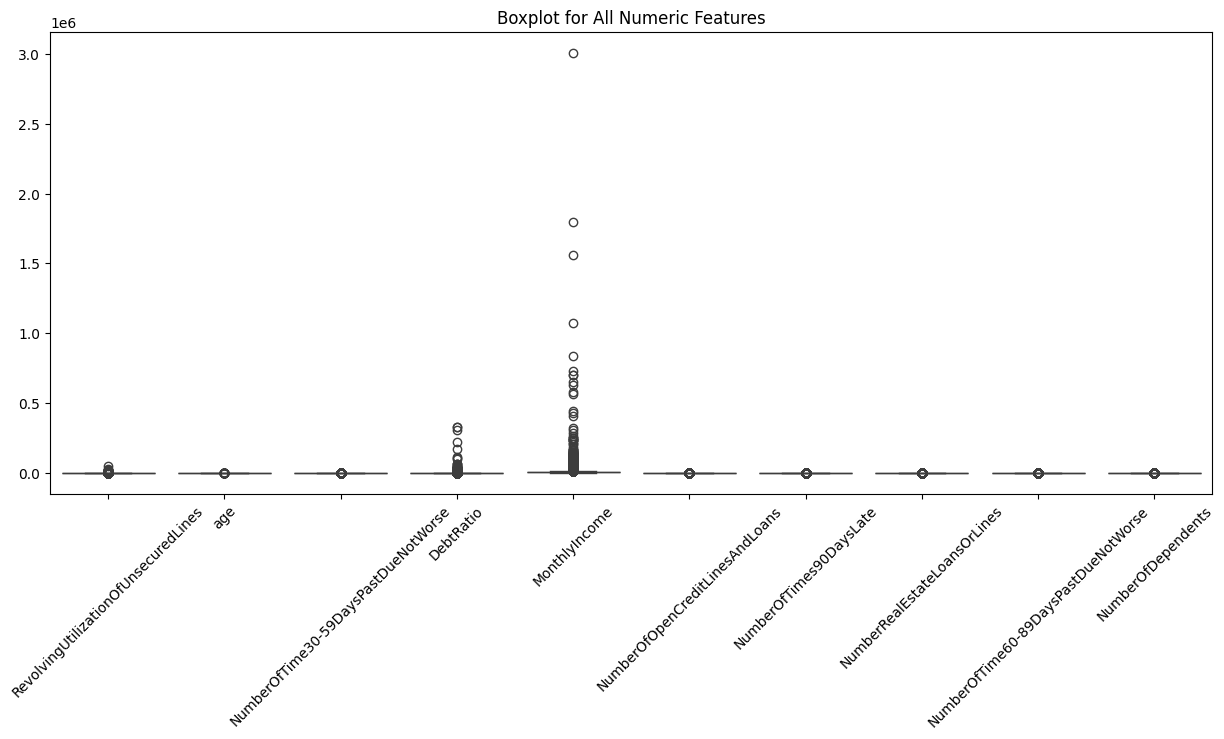

In [229]:
# Drop outliers
numeric_df = df_features.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()
outliers_idx = df_features['MonthlyIncome'].nlargest(1).index
df_features = df_features.drop(index=outliers_idx)
target = target.drop(index=outliers_idx)

In [230]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [231]:
# Engineer_features
df_engi = engineer_features(X_train)

Engineered features


In [232]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_engi, threshold=0.3)

Dropping 0 columns at missing threshold >30%


In [233]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

Dropping 0 high-cardinality columns (> 50 unique values)


Dropping 0 highly correlated features


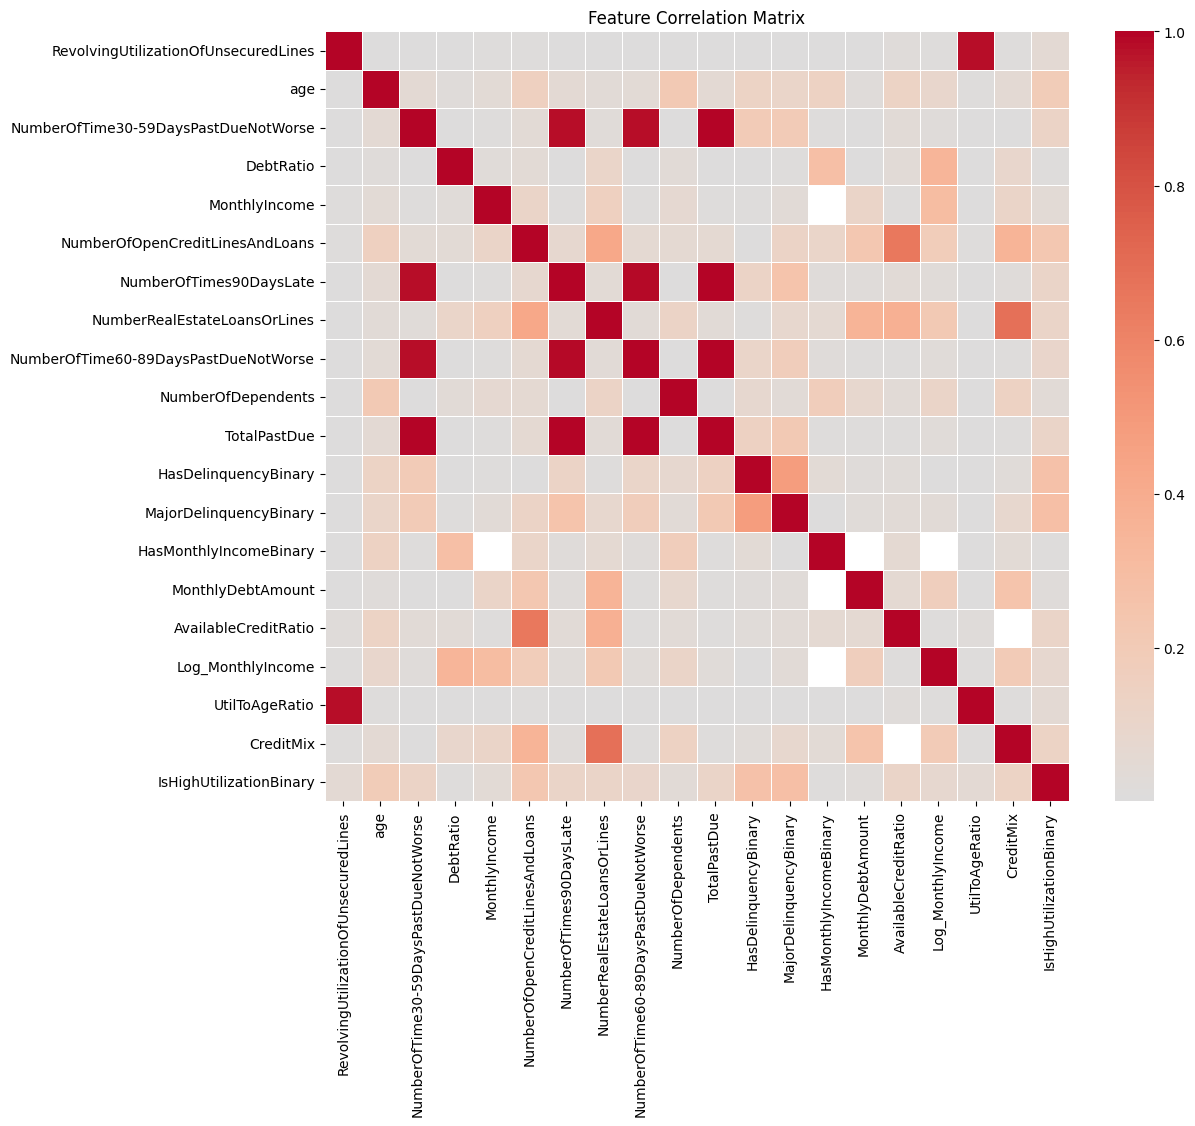

In [234]:
# Drop correlated features here
df_corr, corr_cols_to_drop = drop_correlated(df_high, threshold=1.1)

In [235]:
# Collapse rare categories on training data
df_collapsed, rare_maps = collapse_rare_categories(df_corr, min_freq=0.005)

Nothing to collapse


In [236]:
# Impute and scale
df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler  = impute_and_scale(df_collapsed, threshold=1.0)

Imputed and scaled features


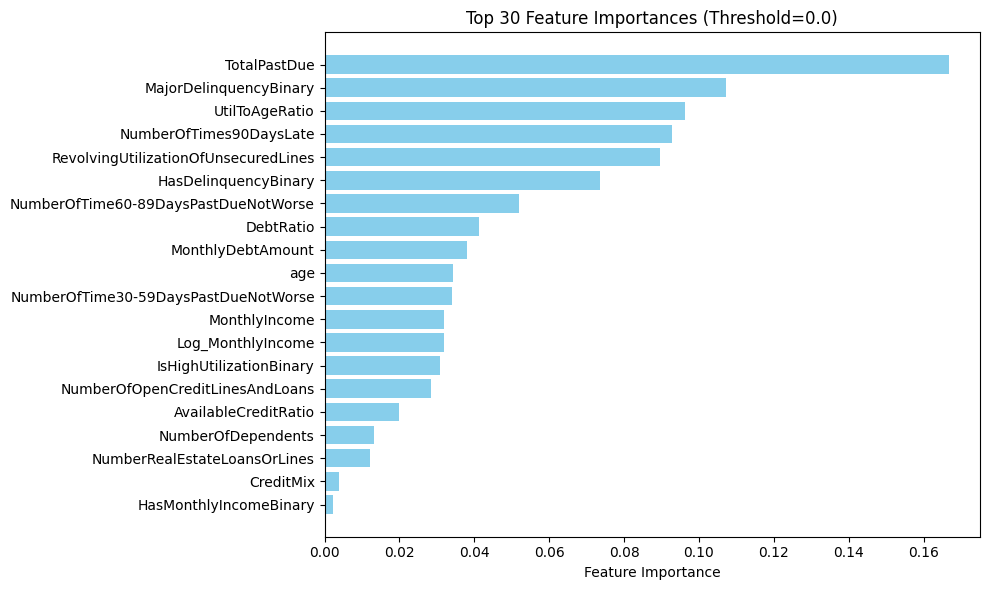

Number of features before selection: 20
Selected 20 features (threshold=0.0)


In [237]:
# Random Forest feature selection
df_selected, selected_features = select_features_rf(df_processed, y_train, threshold=0.0, top_n=30)

In [238]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + corr_cols_to_drop + hc_cols_to_drop

X_val = engineer_features(X_val)
X_val = transform_val_test(X_val, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)

X_test = engineer_features(X_test)
X_test = transform_val_test(X_test, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)
X_train = df_selected.copy()

Engineered features
Engineered features


In [239]:
#summary
print(dataset_summary(X_train))

Dataset shape: (95609, 20)
Total rows: 95609
Total duplicate rows: 74
                                        dtype  non_null_count  missing_count  \
TotalPastDue                          float32           95609              0   
MajorDelinquencyBinary                float32           95609              0   
UtilToAgeRatio                        float32           95609              0   
NumberOfTimes90DaysLate               float32           95609              0   
RevolvingUtilizationOfUnsecuredLines  float32           95609              0   
HasDelinquencyBinary                  float32           95609              0   
NumberOfTime60-89DaysPastDueNotWorse  float32           95609              0   
DebtRatio                             float32           95609              0   
MonthlyDebtAmount                     float32           95609              0   
age                                   float32           95609              0   
NumberOfTime30-59DaysPastDueNotWorse  float32     

In [240]:
# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)  
y_val = le.transform(y_val)       
y_test = le.transform(y_test)    

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("Test shape: ", X_test.shape)

missing_val_cols = set(X_train.columns) - set(X_val.columns)
missing_test_cols = set(X_train.columns) - set(X_test.columns)
print("Missing in val:", missing_val_cols)
print("Missing in test:", missing_test_cols)

print("NaNs in train:", X_train.isna().sum().sum())
print("NaNs in val:", X_val.isna().sum().sum())
print("NaNs in test:", X_test.isna().sum().sum())

Train shape: (95609, 22)
Val shape:   (23903, 22)
Test shape:  (29878, 22)
Missing in val: set()
Missing in test: set()
NaNs in train: 0
NaNs in val: 0
NaNs in test: 0


In [241]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

In [242]:
# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 95609, Val: 23903, Test: 29878


In [243]:
# Model
class NN(nn.Module):
    def __init__(self, num_input):
        super().__init__()
        self.fc1 = nn.Linear(num_input, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 1)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = self.act(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.out(x)         
        return x.squeeze(1)

num_input = X_train.shape[1]  
model = NN(num_input).to(device)

print(model)
sum(p.numel() for p in model.parameters())

NN(
  (fc1): Linear(in_features=22, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
)


39681

In [244]:
# Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

loss_fn = BinaryFocalLoss(alpha=0.93, gamma=2)

In [245]:
# Train
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

best_model_state = None
best_auc = 0.0
patience_counter = 0
patience = 17 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.to(device); yb = yb.to(device).float()
        optimizer.zero_grad()
        logits = model(Xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    
    model.eval()
    val_logits = []
    val_labels = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            val_logits.append(logits.cpu())
            val_labels.append(yb)

    val_logits = torch.cat(val_logits)
    val_labels = torch.cat(val_labels)
    val_probs = torch.sigmoid(val_logits).numpy()
    val_auc = roc_auc_score(val_labels.numpy(), val_probs)

    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.6f} | Val AUC: {val_auc:.4f}")

model.load_state_dict(best_model_state)
print(f"Best model (val_auc={best_auc:.4f}) restored")

Epoch 1/75 | Train loss: 0.062031 | Val AUC: 0.8279
Epoch 2/75 | Train loss: 0.056177 | Val AUC: 0.7595
Epoch 3/75 | Train loss: 0.052741 | Val AUC: 0.8097
Epoch 4/75 | Train loss: 0.052192 | Val AUC: 0.8367
Epoch 5/75 | Train loss: 0.050914 | Val AUC: 0.8343
Epoch 6/75 | Train loss: 0.050510 | Val AUC: 0.8232
Epoch 7/75 | Train loss: 0.050132 | Val AUC: 0.8348
Epoch 8/75 | Train loss: 0.049884 | Val AUC: 0.8377
Epoch 9/75 | Train loss: 0.049667 | Val AUC: 0.8211
Epoch 10/75 | Train loss: 0.049625 | Val AUC: 0.8214
Epoch 11/75 | Train loss: 0.049404 | Val AUC: 0.8345
Epoch 12/75 | Train loss: 0.049216 | Val AUC: 0.8383
Epoch 13/75 | Train loss: 0.049313 | Val AUC: 0.8343
Epoch 14/75 | Train loss: 0.048897 | Val AUC: 0.8430
Epoch 15/75 | Train loss: 0.049023 | Val AUC: 0.8330
Epoch 16/75 | Train loss: 0.048913 | Val AUC: 0.8392
Epoch 17/75 | Train loss: 0.048970 | Val AUC: 0.8423
Epoch 18/75 | Train loss: 0.048434 | Val AUC: 0.8198
Epoch 19/75 | Train loss: 0.048545 | Val AUC: 0.8320
Ep

Best threshold for F1: 0.3120373
              precision    recall  f1-score   support

      Repaid       0.96      0.96      0.96     27876
   Defaulted       0.44      0.40      0.42      2002

    accuracy                           0.93     29878
   macro avg       0.70      0.68      0.69     29878
weighted avg       0.92      0.93      0.92     29878

Accuracy: 92.53%
ROC AUC: 0.839
TP=807, FP=1037, TN=26839, FN=1195
Accuracy for class 'Repaid': 96.28%
Accuracy for class 'Defaulted': 40.31%


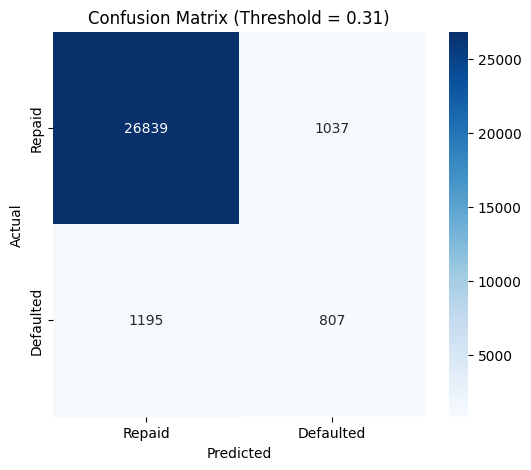

In [246]:
model.eval()
y_val_probs = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)  
        y_val_probs.extend(probs.cpu().numpy())
y_val_probs = np.array(y_val_probs)
y_val_true = y_val 

prec, rec, thresholds = precision_recall_curve(y_val_true, y_val_probs)

beta = 0.9
beta_sq = beta**2
denom = beta_sq * prec[:-1] + rec[:-1]
fbeta = np.zeros_like(denom)
mask = denom != 0
fbeta[mask] = (1 + beta_sq) * prec[:-1][mask] * rec[:-1][mask] / denom[mask]
best_thresh = thresholds[np.argmax(fbeta)]

y_test_probs = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())
y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F1:", best_thresh)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()

In [247]:
# Data sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test) 

In [248]:
# Model
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"], 
    "eta": 0.03,
    "max_depth": 4,
    "min_child_weight": 2, 
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0.1,             
    "lambda": 1.5, 
    "alpha": 0.3, 
    "seed": 42,
    "scale_pos_weight": scale_pos_weight
}

evals = [(dtrain, "train"), (dval, "validation")]

scale_pos_weight: 13.924914142990946


In [249]:
# Train
model_b = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-logloss:0.68195	train-auc:0.85117	validation-logloss:0.68197	validation-auc:0.85015
[50]	train-logloss:0.48064	train-auc:0.86460	validation-logloss:0.48129	validation-auc:0.86229
[100]	train-logloss:0.45511	train-auc:0.86865	validation-logloss:0.45713	validation-auc:0.86458
[150]	train-logloss:0.44771	train-auc:0.87228	validation-logloss:0.45097	validation-auc:0.86611
[200]	train-logloss:0.44361	train-auc:0.87503	validation-logloss:0.44787	validation-auc:0.86653
[250]	train-logloss:0.44013	train-auc:0.87724	validation-logloss:0.44541	validation-auc:0.86650
[255]	train-logloss:0.43979	train-auc:0.87746	validation-logloss:0.44511	validation-auc:0.86654


              precision    recall  f1-score   support

      Repaid       0.96      0.96      0.96     27876
   Defaulted       0.45      0.48      0.46      2002

    accuracy                           0.93     29878
   macro avg       0.71      0.72      0.71     29878
weighted avg       0.93      0.93      0.93     29878

Accuracy: 92.59%
ROC AUC: 0.866
TP=953, FP=1166, TN=26710, FN=1049
Accuracy for class 'Repaid': 95.82%
Accuracy for class 'Defaulted': 47.60%


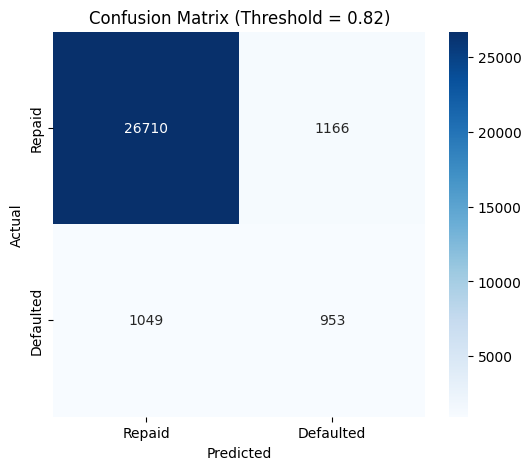

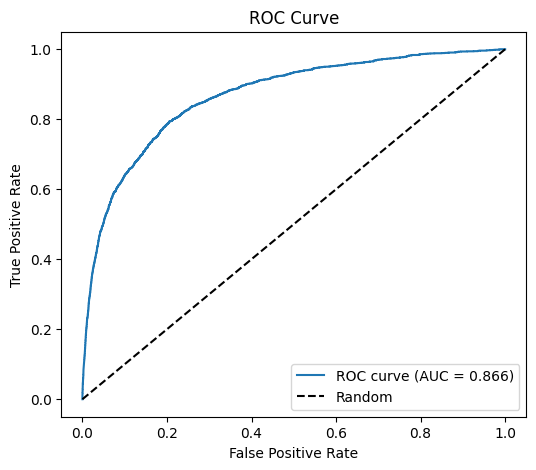

Best threshold for F1: 0.8217537


In [250]:
# Evaluation
y_probs = model_b.predict(dtest) 

prec, rec, thresholds = precision_recall_curve(y_test, y_probs)

beta = 0.9
beta_sq = beta**2
denom = beta_sq * prec[:-1] + rec[:-1]
fbeta = np.zeros_like(denom)
mask = denom != 0
fbeta[mask] = (1 + beta_sq) * prec[:-1][mask] * rec[:-1][mask] / denom[mask]

best_thresh = thresholds[np.argmax(fbeta)]

y_pred_opt = (y_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_pred_opt)
cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_probs) 
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print("Best threshold for F1:", best_thresh)